In [1]:
import os 
os.chdir('../../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.baseline_functions as base
import stumps
import RiskSLIM as slim

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

# restore saved variables
%store -r summary_violent6_KY_interpret

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test
no stored variable summary_violent6_KY_interpret


C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



### CART & EBM

In [2]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
data = data.drop(['fta_risk_score_raw','nca_risk_score_raw','pvf_risk_score_raw', 
                  'fta_calc', 'nca_calc', 'pvf_calc'], axis=1)
x = data.loc[:,:'current_violence']
y = data['recid_violence_six_month'].values

In [3]:
#### CART
depth = [6,7]
cart_summary = base.CART(X=x,
                         Y=y,
                         depth=depth,
                         seed=816)

#### EBM
estimators = [20]
depth = [2]
learning_rate = [0.3]
ebm_summary = base.EBM(X=x,
                       Y=y,
                       learning_rate=learning_rate,
                       depth=depth,
                       estimators=estimators,
                       seed =816)

model_id, score_thresholds 0 {'rank_abs': [5]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [9]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [7]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [8]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [13]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [16]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [14]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [14]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [16]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [18]}
get_disparity_predefined_group()


In [4]:
np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])

(0.8719905277756279, 0.010895672119920975)

In [5]:
np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])

(0.8760153188919686, 0.00753340214344278)

## Lasso Stumps

In [6]:
## load whole data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
X_stumps, Y_stumps = data.loc[:,:'current_violence>=1'], data['recid_violence_six_month'].values
Y_stumps[Y_stumps == -1] = 0
cols = X_stumps.columns[3:]

## load train & test data
train_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_train_stumps.csv")
test_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_test_stumps.csv")

X_train_stumps, Y_train_stumps = train_stumps.loc[:,:'current_violence>=1'], train_stumps['recid_violence_six_month'].values
X_test_stumps, Y_test_stumps = test_stumps.loc[:,:'current_violence>=1'], test_stumps['recid_violence_six_month'].values

Y_train_stumps[Y_train_stumps == -1] = 0
Y_test_stumps[Y_test_stumps == -1] = 0

#### Nested Cross Validation

In [7]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.007, 0.005, 0.003]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [10284]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [10089]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [9588]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [10396]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [9963]}
get_disparity_predefined_group()


In [9]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

({'C': 0.007}, 0.8787057958473353, 0.00264705924661901)

##### Best Stump Model

In [12]:
best_stump_model = stumps.stump_model(X_train_stumps, Y_train_stumps, 
                                      X_test_stumps, Y_test_stumps, 
                                      c=0.003, columns=cols, seed=816)

##### Prediction Table

In [13]:
stumps.stump_table(best_stump_model['coefs'], 
                   best_stump_model['features'], 
                   best_stump_model['intercept'], 
                   best_stump_model['dictionary'])

+-----------------------------------+----------------+
| Features                          | Score          |
|====================================================|
| sex                               | 37.1           |
| age_at_current_charge<=30         | 4.4            |
| age_at_current_charge<=38         | 7.0            |
| age_at_current_charge<=43         | 7.2            |
| p_arrest>=1                       | -86.8          |
| p_arrest>=2                       | 28.4           |
| p_arrest>=3                       | 42.5           |
| p_arrest>=5                       | 18.7           |
| p_arrest>=7                       | 7.1            |
| p_charges>=1                      | -77.2          |
| p_charges>=2                      | 2.4            |
| p_charges>=3                      | 2.3            |
| p_charges>=6                      | 3.0            |
| p_violence>=1                     | 215.2          |
| p_felony>=1                       | 21.1           |
| p_misdem

In [14]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.003]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [9176]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [9235]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [8934]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [9139]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [9471]}
get_disparity_predefined_group()


In [15]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

({'C': 0.003}, 0.8769661471769684, 0.0017833029209550987)

##### Stumps Visualizations

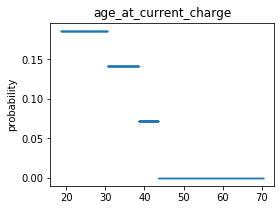

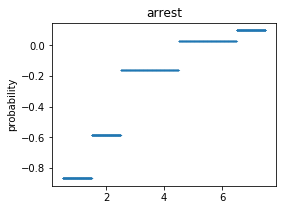

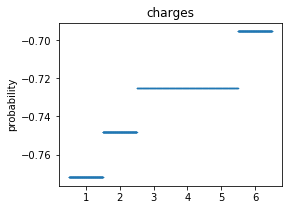

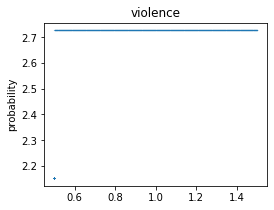

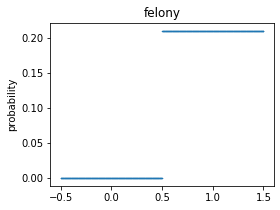

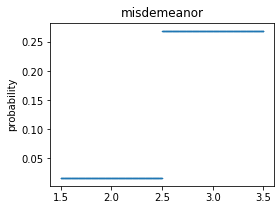

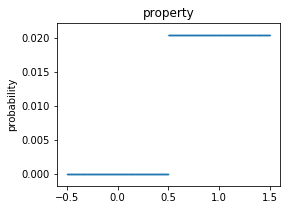

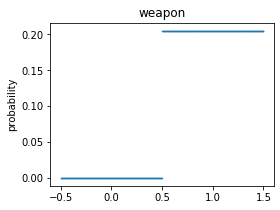

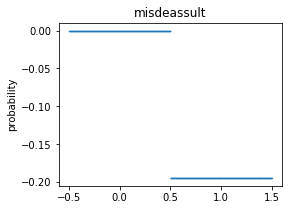

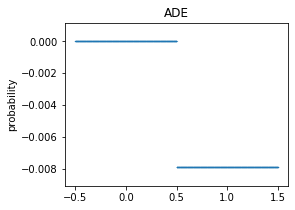

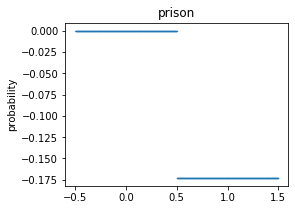

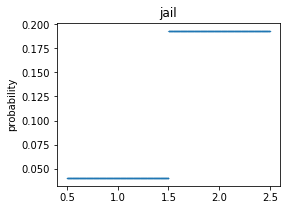

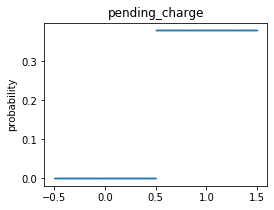

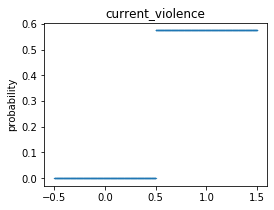

In [16]:
stumps.stump_plots(best_stump_model['features'], best_stump_model['coefs'])

### Arnold PSA

In [17]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
X_arnold_raw = data['nca_risk_score_raw'].values
X_arnold_calc = data['nca_calc'].values
Y_arnold = data['recid_violence_six_month'].values

In [18]:
## set up cross validation
cv = KFold(n_splits=5,shuffle=True,random_state=816)
raw_auc = []
calc_auc = []

## raw score
i = 1
for train, test in cv.split(X_arnold_raw, Y_arnold):
    y_pred_raw, y_pred_calc, y_test = X_arnold_raw[test], X_arnold_calc[test], Y_arnold[test]
    raw_auc.append(roc_auc_score(y_test, y_pred_raw))
    calc_auc.append(roc_auc_score(y_test, y_pred_calc))
    i+=1 

## RiskSLIM

In [19]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
x, y = data.loc[:,:'current_violence>=1'], data['recid_violence_six_month'].values
cols = x.columns[3:]

In [20]:
## train on best param chosen by Lasso Stumps from above
x_train = x.copy().drop(['race', 'person_id', 'screening_date'], axis=1)
lasso = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.003, random_state=816).fit(x_train,y)
selected_features = cols[lasso.coef_[0] != 0].tolist()
len(selected_features)

30

In [21]:
### Subset features
if 'sex' in selected_features:
    selected_features = ['recid_violence_six_month', 'person_id', 'screening_date', 'race'] + selected_features
    indicator = 1
else:
    selected_features = ['recid_violence_six_month', 'person_id', 'screening_date', 'race', 'sex'] + selected_features
    indicator = 0

sub_data = data[selected_features]
sub_X, sub_Y = sub_data.iloc[:,1:], sub_data.iloc[:,0].values
sub_X.insert(0, '(Intercept)', 1)

In [22]:
riskslim_summary = slim.risk_cv(X=sub_X, 
                                Y=sub_Y, 
                                indicator = indicator,
                                y_label='recid_violent6', 
                                max_coef=20, 
                                max_coef_number=10, 
                                max_runtime=200, 
                                c=1e-5, 
                                seed=816)

setting c0 = 0.0 to ensure that intercept is not penalized
09/11/19 @ 04:08 PM | 1301 rows in lookup table
09/11/19 @ 04:08 PM | ------------------------------------------------------------
09/11/19 @ 04:08 PM | runnning initialization procedure
09/11/19 @ 04:08 PM | ------------------------------------------------------------
09/11/19 @ 04:08 PM | CPA produced 2 cuts
09/11/19 @ 04:08 PM | running naive rounding on 103 solutions
09/11/19 @ 04:08 PM | best objective value: 0.0750
09/11/19 @ 04:08 PM | rounding produced 5 integer solutions
09/11/19 @ 04:08 PM | best objective value is 0.0766
09/11/19 @ 04:08 PM | running sequential rounding on 103 solutions
09/11/19 @ 04:08 PM | best objective value: 0.0750
09/11/19 @ 04:08 PM | sequential rounding produced 6 integer solutions
09/11/19 @ 04:08 PM | best objective value: 0.0762
09/11/19 @ 04:08 PM | polishing 11 solutions
09/11/19 @ 04:08 PM | best objective value: 0.0762
09/11/19 @ 04:08 PM | polishing produced 4 integer solutions
09/11/

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 04:08 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.0762.
Tried aggregator 1 time.
Reduced MIP has 32 rows, 64 columns, and 123 nonzeros.
Reduced MIP has 30 binaries, 32 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

  63996 28602        cutoff              0.0760        0.0738   306298    2.88%           rho_0 U  63996  63995     82
  65158 28887        0.0739    10        0.0760        0.0738   309470    2.88%          rho_11 U  65158  65156    104
  66101 29557        0.0740    13        0.0760        0.0738   315303    2.88%          rho_12 D  66101  65886     19
  67197 30199        0.0738    11        0.0760        0.0738   320598    2.88%           rho_0 D  67197  67195     76
  67880 30742        0.0741    11        0.0760        0.0738   325069    2.88%          rho_20 D  67880  67879     24
  68635 31227        0.0747     7        0.0760        0.0738   329124    2.88%           rho_0 U  68635  68634     29
  69370 31525        0.0738    11        0.0760        0.0738   334280    2.88%           rho_1 U  69370  69369     16
  70138 31989        0.0749     9        0.0760        0.0738   338176    2.88%          rho_21 U  70138  70137     27
Elapsed time = 43.47 sec. (50824.44 ticks, tree 

 143880 74604        0.0751     5        0.0759        0.0738   837682    2.77%          rho_21 D 143880 143879     86
 145837 75909        0.0755     4        0.0759        0.0738   857343    2.77%           rho_8 D 145837 145836     28
 148140 77581        0.0745    11        0.0759        0.0738   873737    2.77%          rho_23 D 148140 148139     34
 150606 78823        0.0738    15        0.0759        0.0738   888567    2.77%          rho_12 D 150606  69920     19
Elapsed time = 141.56 sec. (168202.79 ticks, tree = 35.60 MB, solutions = 5)
 152897 80198        0.0746    12        0.0759        0.0738   904500    2.77%           rho_5 U 152897 152895     59
 155224 81635        cutoff              0.0759        0.0738   919637    2.77%          rho_12 U 155224 155223     43
 157450 82814        0.0745    11        0.0759        0.0738   934432    2.77%          rho_23 D 157450 157449     94
 159849 84201        0.0739    18        0.0759        0.0738   948709    2.77%          r

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 04:12 PM | adding 251 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.0761.
Tried aggregator 1 time.
Reduced MIP has 32 rows, 64 columns, and 123 nonzeros.
Reduced MIP has 30 binaries, 32 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

  48237 20831        0.0734     1        0.0755        0.0734   247137    2.81%          rho_11 U  48237  48235     59
  49293 21179        cutoff              0.0755        0.0734   251432    2.81%           rho_0 U  49293  49292     54
  50326 21510        0.0734     1        0.0755        0.0734   255633    2.81%          rho_11 U  50326  50324     93
  51299 21943        0.0741     5        0.0755        0.0734   260760    2.81%          rho_26 D  51299  51297     53
  52227 22382        cutoff              0.0755        0.0734   266169    2.81%          rho_14 U  52227  52226     62
  53034 22905        0.0734     8        0.0755        0.0734   272252    2.81%          rho_11 U  53034  53032     84
  53836 23409        0.0736     6        0.0755        0.0734   278114    2.81%          rho_12 D  53836  53835     84
  54756 23810        0.0746     5        0.0755        0.0734   282167    2.81%          rho_27 U  54756  54755     38
  55650 24190        0.0748     1        0.0755 

 128286 61622        0.0734    11        0.0755        0.0734   702592    2.81%           rho_0 D 128286 128284     54
 131203 62943        cutoff              0.0755        0.0734   720108    2.81%          rho_29 U 131203 131202     62
 134201 64367        0.0745     8        0.0755        0.0734   737853    2.81%           rho_0 U 134201 134200     52
 136820 65915        0.0734    14        0.0755        0.0734   753352    2.81%          rho_11 U 136820 136819     27
 138766 67079        cutoff              0.0755        0.0734   768562    2.81%          rho_23 U 138766 138765     29
Elapsed time = 137.94 sec. (167371.77 ticks, tree = 32.92 MB, solutions = 9)
 140922 68324        0.0739    11        0.0755        0.0734   781061    2.81%           rho_0 U 140922 140921     56
 142989 69607        cutoff              0.0755        0.0734   793504    2.81%           rho_8 U 142989 142988     55
 145158 70632        0.0746    16        0.0755        0.0734   806605    2.81%           

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 04:15 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.0769.
Tried aggregator 1 time.
Reduced MIP has 32 rows, 64 columns, and 123 nonzeros.
Reduced MIP has 30 binaries, 32 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

  71515 33313        0.0744    10        0.0762        0.0741   381435    2.74%          rho_11 U  71515  71513     57
* 71997 33499      integral     0        0.0762        0.0741   383509    2.73%
  72623 33846        0.0741    10        0.0762        0.0741   387522    2.73%           rho_0 D  72623  72621     31
  73794 34487        0.0741     4        0.0762        0.0741   393173    2.73%          rho_11 U  73794  73792     45
  75090 35177        0.0741     9        0.0762        0.0741   397634    2.73%          rho_11 D  75090  75089     72
  76207 35713        cutoff              0.0762        0.0741   401733    2.73%          rho_14 U  76207  76206     35
  77337 36276        0.0741     6        0.0762        0.0741   407829    2.73%          rho_11 U  77337  77335     32
  78195 36703        0.0743     7        0.0762        0.0741   414405    2.73%           rho_0 D  78195  78193     25
  79322 37216        0.0762     7        0.0762        0.0741   421523    2.73%        

 179726 79623        0.0755     3        0.0762        0.0741  1062327    2.73%          rho_17 D 179726 179724    113
 182568 80971        0.0749     7        0.0762        0.0741  1082208    2.73%          rho_12 D 182568 182566     25
 185146 82579        cutoff              0.0762        0.0741  1105008    2.73%          rho_14 U 185146 185145     58
 187513 84002        0.0741     9        0.0762        0.0741  1130428    2.73%          rho_11 U 187513 187511     71
Elapsed time = 162.20 sec. (168165.20 ticks, tree = 35.10 MB, solutions = 5)
 190040 85262        0.0761     3        0.0762        0.0741  1153039    2.73%          rho_14 U 190040 190038     32
 192968 86680        0.0744    18        0.0762        0.0741  1172777    2.73%          rho_15 U 192968 192630     14
 195834 88096        0.0754     5        0.0762        0.0741  1193007    2.73%          rho_18 D 195834 195832     30
 198854 89402        0.0754     5        0.0762        0.0741  1217123    2.73%          r

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 04:19 PM | adding 250 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.0758.
Tried aggregator 1 time.
Reduced MIP has 32 rows, 64 columns, and 123 nonzeros.
Reduced MIP has 30 binaries, 32 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

  63222 27371        0.0756     7        0.0758        0.0737   339581    2.68%          rho_28 D  63222  63221     22
  64272 27723        0.0743     1        0.0758        0.0737   343652    2.68%          rho_13 D  64272  64271     34
  65262 27865        0.0752     5        0.0758        0.0737   347190    2.68%          rho_18 D  65262  65260     67
  66268 28014        cutoff              0.0758        0.0737   350813    2.68%          rho_24 N  66268  66267     77
  67247 28156        cutoff              0.0758        0.0737   354357    2.68%          rho_24 N  67247  67246    103
  68221 28295        0.0757     5        0.0758        0.0737   357957    2.68%          rho_14 D  68221  68219     80
Elapsed time = 49.09 sec. (50820.22 ticks, tree = 10.74 MB, solutions = 1)
  69203 28437        0.0757     5        0.0758        0.0737   361557    2.68%          rho_14 D  69203  69201     84
  70193 28580        0.0745     7        0.0758        0.0737   365370    2.68%          rho

 146952 69264        0.0738    14        0.0757        0.0737   911942    2.64%           rho_0 D 146952 146950     36
 149241 70767        0.0737    13        0.0757        0.0737   928446    2.64%          rho_11 U 149241 134483     39
Elapsed time = 152.92 sec. (168204.18 ticks, tree = 32.37 MB, solutions = 2)
*150000+71110                            0.0757        0.0737             2.63%
 151528 71898        0.0739    18        0.0757        0.0737   947177    2.63%          rho_19 D 151528 151527     13
 153927 73376        0.0751     9        0.0757        0.0737   962458    2.63%           rho_4 D 153927 153925     64
 156368 74967        0.0738    13        0.0757        0.0737   977655    2.63%          rho_15 U 156368  63185     22
 158949 76270        0.0738    11        0.0757        0.0737   993208    2.63%           rho_6 D 158949 158362     26
 161550 77660        0.0740    12        0.0757        0.0737  1008122    2.63%          rho_30 D 161550 161549     38
 163998 79

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 04:23 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.0765.
Tried aggregator 1 time.
Reduced MIP has 32 rows, 64 columns, and 123 nonzeros.
Reduced MIP has 30 binaries, 32 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.07 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

  54295 22667        0.0749     9        0.0760        0.0739   292114    2.71%           rho_0 U  54295  54294     58
  55151 23026        0.0739    10        0.0760        0.0739   296195    2.71%           rho_0 D  55151  55133     32
  55888 23435        0.0747    15        0.0760        0.0739   300959    2.71%          rho_16 U  55888  55886     14
  56613 23862        0.0745     7        0.0760        0.0739   305333    2.71%           rho_4 D  56613  56611     22
  57260 24229        0.0750     8        0.0760        0.0739   309419    2.71%           rho_5 D  57260  57259     34
  57931 24700        0.0749    15        0.0760        0.0739   312855    2.71%           rho_5 D  57931  57930     42
  58585 25098        0.0749     8        0.0760        0.0739   316668    2.71%           rho_0 U  58585  58584     39
  59290 25486        0.0741    17        0.0760        0.0739   320450    2.71%          rho_23 U  59290  59289     18
  59954 25921        0.0744    15        0.0760 

 132035 63104        0.0744    14        0.0760        0.0739   777457    2.71%           rho_5 U 132035 132033     39
 134000 64207        0.0739    17        0.0760        0.0739   795261    2.71%          rho_11 D 134000 133999     59
 135795 65006        0.0741    15        0.0760        0.0739   817926    2.71%           rho_8 D 135795 135794     72
 137876 66163        cutoff              0.0760        0.0739   832728    2.71%          rho_29 U 137876 137875     35
 140075 67369        0.0752     7        0.0760        0.0739   846524    2.71%          rho_12 D 140075 140073     30
Elapsed time = 170.95 sec. (168235.49 ticks, tree = 32.13 MB, solutions = 7)
 142270 68654        0.0750     8        0.0760        0.0739   862619    2.71%           rho_0 D 142270 142268     37
 144410 69924        0.0748     7        0.0760        0.0739   878941    2.71%           rho_3 D 144410 144409     28
 146519 71180        0.0752    17        0.0760        0.0739   896243    2.71%          r

In [23]:
np.mean(riskslim_summary['train_auc']), np.mean(riskslim_summary['test_auc'])

(0.8622797420121368, 0.8603815687059303)

### Results

In [24]:
#### save results
summary_violent6_KY_interpret = {"CART": cart_summary,
                                   "EBM": ebm_summary, 
                                   'Lasso Stumps': stump_summary, 
                                   'RiskSLIM': riskslim_summary, 
                                   'Arnold PSA Raw': raw_auc, 
                                   'Arnold PSA': calc_auc}
%store summary_violent6_KY_interpret

Stored 'summary_violent6_KY_interpret' (dict)


In [25]:
results = [["CART", np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])],
           ["EBM", np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])], 
           ["Lasso Stumps", np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])],
           ['RiskSLIM', np.mean(riskslim_summary['test_auc'])],
           ['Arnold PSA Raw', round(np.mean(raw_auc), 3)], 
           ['Arnold PSA', round(np.mean(calc_auc), 3)]]
results

[['CART', 0.8719905277756279, 0.010895672119920975],
 ['EBM', 0.8760153188919686, 0.00753340214344278],
 ['Lasso Stumps', 0.8769661471769684, 0.0017833029209550987],
 ['RiskSLIM', 0.8603815687059303],
 ['Arnold PSA Raw', 0.709],
 ['Arnold PSA', 0.693]]

In [26]:
auc = [np.mean(cart_summary['holdout_test_auc']), 
       np.mean(ebm_summary['holdout_test_auc']), 
       np.mean(stump_summary['holdout_test_auc']), 
       np.mean(riskslim_summary['test_auc'])]

In [27]:
path = "C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY Results/Models/Six Month/"
results = [["Violent", np.str((round(np.mean(cart_summary['holdout_test_auc']), 3))) + " (" + np.str(round(np.std(cart_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(ebm_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(ebm_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(stump_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(stump_summary['holdout_test_auc']), 3)) + ")",             
            np.str(round(np.mean(riskslim_summary['test_auc']),3)) + " (" + np.str(round(np.std(riskslim_summary['test_auc']), 3)) + ")", 
            round(np.max(auc) - np.min(auc), 3),
            np.str(round(np.mean(raw_auc), 3)) + " (" + np.str(round(np.std(raw_auc),3)) + ")", 
            np.str(round(np.mean(calc_auc), 3)) + " (" + np.str(round(np.std(calc_auc),3)) + ")"]]
with open(path + 'Interpretable Models Summary.csv', 'a') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)